Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
from skimage import io, transform
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras import Model

Importing Dataset, Visualizing Images, Creating Input

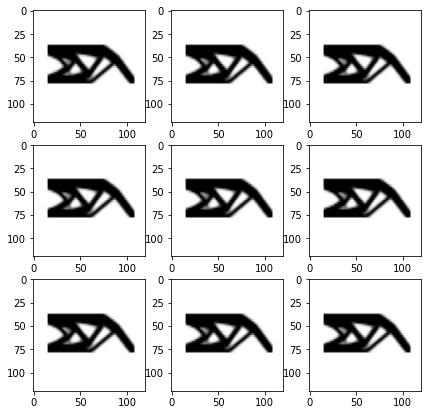

In [2]:
#Importing the images
Image_path = 'D:\MTP_P1\W10\Trial_2D_TopDeep\Excel_data\img'
coll = skimage.io.ImageCollection(Image_path + '/*.png') 

#coll has the images as they are in the directory i.e is sorted order, also name of files can be viewed as coll.files[0] , shape as col[0].shape
width = 120
length = 120
# Now we will resize the image into 50*100 (width*length) , for that first we make a list as assignment is not allowed in ImageCollection, then push list itemps to a numpy array of required size
img_list = []
for i in range(len(coll)):
    img = transform.resize(coll[i], output_shape=(width,length))
    img_list.append(img)

img_arr = np.empty((120,width,length,3)) #initializes an empty numpy array which will contain 120 entries, each entry will be a 3 stacked matrices.
for i in range(120):
    img_arr[i] = np.asarray(img_list[i])

#visualizing the images
fig = plt.figure(figsize=(7, 7))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = img_arr[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

#now corresponding to each image we need an input tensor of size 50*100*3, matrices will contain volumefrac, fy , fx
top_set = np.empty((120,width,length,3))
#now we import our excel sheet which will provide the values with which we will populate our matrices
set_data = pd.read_excel("Top_setting.xlsx").values # .values will remove the headers i.e name of the columns

#updating the top_set to create our input with shape 120*50*100*3

for i in range(top_set.shape[0]):
    for j in range(top_set.shape[1]):
        for k in range(top_set.shape[2]):
            for l in range(top_set.shape[3]):
                top_set[i][j][k][l] = set_data[i][l]

# Now we have our input and outputs:
# input = top_set : shape - (120, 100, 100, 3)
# output = img_arr : shape - (120, 100, 100, 3)

Train-Test Split and Normalization

In [3]:
X_train, X_test, y_train, y_test = train_test_split( top_set, img_arr, test_size=0.2, random_state=0)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Building Variational - AutoEncoder Model

Building Encoder Part

In [4]:
inputs = tf.keras.layers.Input(shape=(length,width,3))
codings_size = 10
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var))*tf.exp(log_var/2) + mean

z = layers.Conv2D(32, 3, activation='relu',strides = 2, padding='same')(inputs)
z = layers.Conv2D(64, 3, activation='relu',strides = 2, padding ='same')(z)

conv_shape = keras.backend.int_shape(z)

z = layers.Flatten()(z)

z = layers.Dense(100, activation ='relu')(z)

codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(inputs, outputs = [codings_mean, codings_log_var, codings])
variational_encoder.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 60, 60, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 57600)        0           ['conv2d_1[0][0]']           

Building Decoder Part

In [5]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])

z = layers.Dense(100, activation ='relu')(decoder_inputs)
z = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(z)
z = layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(z)

z = layers.Conv2DTranspose(64, 3, activation = 'relu' , strides = 2, padding = 'same')(z)
z = layers.Conv2DTranspose(32, 3, activation = 'relu' , strides = 2, padding = 'same')(z)

outputs = layers.Conv2DTranspose(3, 3, activation = 'sigmoid', padding = 'same')(z)

variational_decoder = tf.keras.Model(decoder_inputs, outputs)
variational_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_3 (Dense)             (None, 100)               1100      
                                                                 
 dense_4 (Dense)             (None, 57600)             5817600   
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 60, 60, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 120, 120, 32)     18464     
 ranspose)                                                 

Ensembling the encoder and decoder to create a Complete Model

In [6]:
codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings[2])
variational_ae = tf.keras.Model(inputs = [inputs],outputs = [reconstructions])
variational_ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 model (Functional)          [(None, 10),              5781512   
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 model_1 (Functional)        (None, 120, 120, 3)       5874959   
                                                                 
Total params: 11,656,471
Trainable params: 11,656,471
Non-trainable params: 0
_________________________________________________________________


Defining Latent Loss/Kl divergence

In [7]:
latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis = -1)
variational_ae.add_loss(tf.reduce_mean(latent_loss)/43200.)

Compilation and Fitting of Model

In [8]:
from sklearn import metrics


variational_ae.compile(loss = "mse", optimizer="nadam", metrics=['accuracy'])
epochs = 30
history = variational_ae.fit(X_train, y_train, epochs = epochs, batch_size=15, validation_data=(X_test, y_test),)

Epoch 1/30
7/7 [==============================] - 5s 391ms/step - loss: 0.2306 - accuracy: 0.0972 - val_loss: 0.2081 - val_accuracy: 0.0796
Epoch 2/30
7/7 [==============================] - 2s 305ms/step - loss: 0.0932 - accuracy: 0.1824 - val_loss: 0.0460 - val_accuracy: 0.2855
Epoch 3/30
7/7 [==============================] - 2s 309ms/step - loss: 0.0414 - accuracy: 0.3170 - val_loss: 0.0355 - val_accuracy: 0.3933
Epoch 4/30
7/7 [==============================] - 2s 294ms/step - loss: 0.0324 - accuracy: 0.5083 - val_loss: 0.0298 - val_accuracy: 0.6329
Epoch 5/30
7/7 [==============================] - 2s 296ms/step - loss: 0.0285 - accuracy: 0.5728 - val_loss: 0.0282 - val_accuracy: 0.4746
Epoch 6/30
7/7 [==============================] - 2s 291ms/step - loss: 0.0276 - accuracy: 0.4235 - val_loss: 0.0275 - val_accuracy: 0.3412
Epoch 7/30
7/7 [==============================] - 2s 296ms/step - loss: 0.0267 - accuracy: 0.3461 - val_loss: 0.0266 - val_accuracy: 0.2867
Epoch 8/30
7/7 [====

Performance Curves

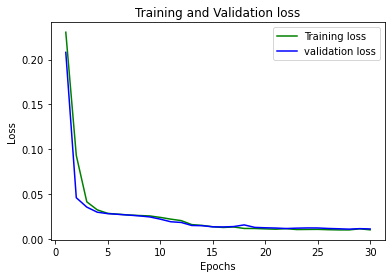

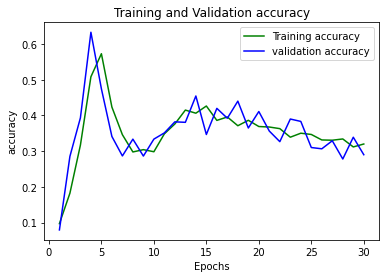

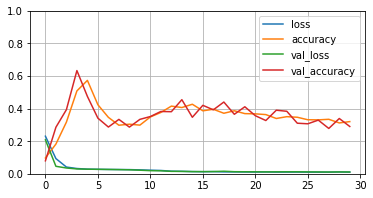

In [9]:
#Loss vs epochs

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Accuracy vs epochs

accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# boths accuracy and loss vs epochs

pd.DataFrame(history.history).plot(figsize=(6,3))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Generating random samples(new instances from learnt probabilty distribution)

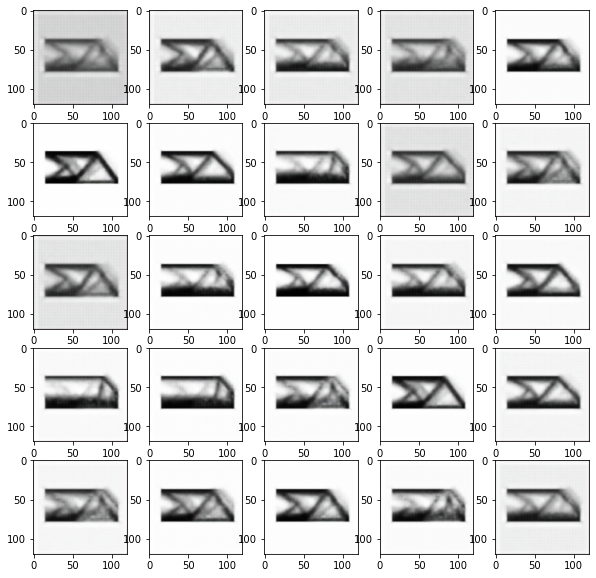

In [10]:
samples = tf.random.normal(shape=[30,codings_size])
images = variational_decoder(samples).numpy()

fig1 = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig1.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
plt.show()


Writing and Saving the results in Excel sheet

In [11]:
import xlsxwriter
 
workbook = xlsxwriter.Workbook('OutPut.xlsx')
worksheet = workbook.add_worksheet()
 
# Start from the first cell.
# Rows and columns are zero indexed.
row = 0
column = 0
 
content = history.history.get('loss')
worksheet.write(row, column, 'loss')
row += 1
# iterating through content list
for item in content :
 
    # write operation perform
    worksheet.write(row, column, item)
 
    # incrementing the value of row by one
    # with each iterations.
    row += 1

row = 0
column = 1
 
content = history.history.get('val_loss')
worksheet.write(row, column, 'val_loss')
row += 1
 
# iterating through content list
for item in content :
 
    # write operation perform
    worksheet.write(row, column, item)
 
    # incrementing the value of row by one
    # with each iterations.
    row += 1

row = 0
column = 2
 
content = history.history.get('accuracy')
worksheet.write(row, column, 'accuracy')
row += 1
 
# iterating through content list
for item in content :
 
    # write operation perform
    worksheet.write(row, column, item)
 
    # incrementing the value of row by one
    # with each iterations.
    row += 1

row = 0
column = 3
 
content = history.history.get('val_accuracy')
worksheet.write(row, column, 'val_accuracy')
row += 1
 
# iterating through content list
for item in content :
 
    # write operation perform
    worksheet.write(row, column, item)
 
    # incrementing the value of row by one
    # with each iterations.
    row += 1


     
workbook.close()